In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys, os, time

C:\Users\actruce\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [5]:
company_list = ['SAMSUNG','HYNIX','NVIDIA','TSMC','APPLE', 'TESLA']

In [6]:
df_list =[]
for company in company_list:
    df_temp = pd.read_csv(f'{company}.csv')
    df_list.append(df_temp)

In [7]:
df_close_list = []

for df in df_list:
    df_mod = df.copy()
    df_mod.drop(['Open','High','Low','Adj Close'], axis=1, inplace=True)
    df_mod.Date = pd.to_datetime(df_mod.Date)
    df_mod.set_index('Date', inplace=True)
    df_mod = df_mod.asfreq('D', method='ffill')
    df_mod.info()
    df_close_list.append(df_mod)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8976 entries, 2000-01-04 to 2024-07-31
Freq: D
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   8976 non-null   float64
 1   Volume  8976 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 210.4 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8976 entries, 2000-01-04 to 2024-07-31
Freq: D
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   8976 non-null   float64
 1   Volume  8976 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 210.4 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8977 entries, 2000-01-03 to 2024-07-31
Freq: D
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   8977 non-null   float64
 1   Volume  8977 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 210.4 KB
<cla

In [8]:
df_close_list[0].head() # samsung

,Close,Volume
Date,,
2000-01-04,6110.0,74195000
2000-01-05,5580.0,74680000
2000-01-06,5620.0,54390000
2000-01-07,5540.0,40305000
2000-01-08,5540.0,40305000


#### 일별 변동률 계산 = ((오늘 종가)/(어제 종가) -1 )*100

In [9]:
df_dpc_list = []

for df in df_close_list:
    df_close = df['Close']
    df_dpc = (df_close/df_close.shift(1) - 1)*100
    df_dpc.name = 'dpc'
    df_dpc.iloc[0] = 0
    df = pd.concat((df, df_dpc), axis=1)
    df_dpc_list.append(df)

In [10]:
df_dpc_list[0].head()

,Close,Volume,dpc
Date,,,
2000-01-04,6110.0,74195000,0.000000
2000-01-05,5580.0,74680000,-8.674304
2000-01-06,5620.0,54390000,0.716846
2000-01-07,5540.0,40305000,-1.423488
2000-01-08,5540.0,40305000,0.000000


In [11]:
# df_dpc_dict['회사'] = df_dpc

df_dpc_dict = dict(zip(company_list, df_dpc_list))

#### 일간 변동률 누적곱 계산 (기하평균 계산) = ((100+일간변동률)/100).cumprod()*100 - 100
- 시작일을 언제로 하느냐에 따라 결과가 달라짐

### 회사별 투자시작 시간을 넣으면 수익률을 리턴하는 함수 작성하여 확인

In [12]:
def get_cur_profit(company, df_dpc_dict, start_date, end_date=None):
    
    df_dpc = df_dpc_dict[company]
    
    if end_date is not None:
        df_dpc_p = df_dpc.loc[start_date:end_date,'dpc']
    else:
        df_dpc_p = df_dpc.loc[start_date:,'dpc']
        
    df_dpc_p.iloc[0] = 0
    df_dpc_p_cp = ((100+df_dpc_p)/100).cumprod()*100 - 100
    df_dpc_p_cp.name = 'dcp_cp'
    
    if end_date is not None:
        df_dpc_p_cp = pd.concat((df_dpc.loc[start_date:end_date], df_dpc_p_cp), axis=1)
    else:
        df_dpc_p_cp = pd.concat((df_dpc.loc[start_date:], df_dpc_p_cp), axis=1)
        
    profit = df_dpc_p_cp.iloc[-1, 3]
    
    return profit, df_dpc_p_cp

In [13]:
company = 'NVIDIA'
start_date, end_date = '2019-09-01', None
profit, df_dpc_p_cp = get_cur_profit(company, df_dpc_dict, start_date, end_date)

print(f'company:{company}, profit:{profit:.2f}')
print(f'start_date:{df_dpc_p_cp.index[0]}->Close:{df_dpc_p_cp.iloc[0,0]}')
print(f'end_date:{df_dpc_p_cp.index[-1]}->Close:{df_dpc_p_cp.iloc[-1,0]}')

company:NVIDIA, profit:2694.34
start_date:2019-09-01 00:00:00->Close:4.187749862670898
end_date:2024-07-31 00:00:00->Close:117.0199966430664


### 회사별 동일 기간의 누적 수익률 그래프

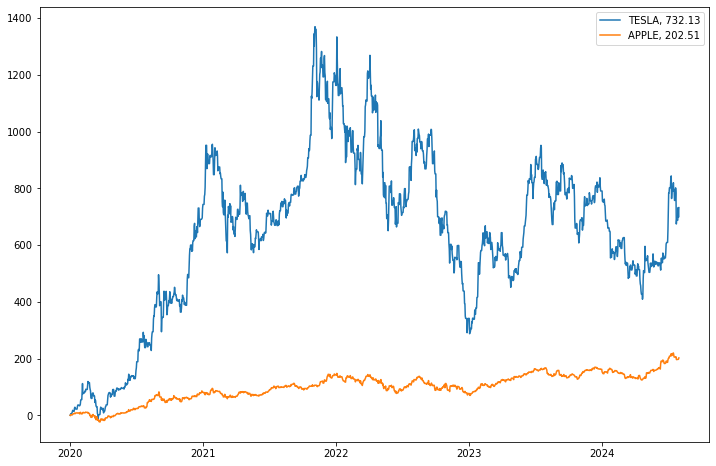

In [20]:
start_date, end_date = '2020-01-01', None

df_dpc_p_cp_list = []
#company_list = ['SAMSUNG','HYNIX','TSMC','APPLE']
company_list = ['TESLA', 'APPLE']

for company in company_list:
    profit, df_dpc_p_cp = get_cur_profit(company, df_dpc_dict, start_date, end_date)
    df_dpc_p_cp_list.append((profit, df_dpc_p_cp))
    
    #print(f'company:{company}, profit:{profit:.2f}')
    #print(f'start_date:{df_dpc_p_cp.index[0]}->Close:{df_dpc_p_cp.iloc[0,0]}')
    #print(f'end_date:{df_dpc_p_cp.index[-1]}->Close:{df_dpc_p_cp.iloc[-1,0]}')
    #print('\n')

fig = plt.figure(figsize=(12,8))    
ax = fig.add_subplot()

for company, (profit, df_dpc_p_cp) in zip(company_list, df_dpc_p_cp_list):
    ax.plot(df_dpc_p_cp['dcp_cp'], label = f'{company}, {profit:.2f}')
    
ax.legend()